In [ ]:
!python3 -c "import lightning" || pip install lightning==2.2.4
!python3 -c "import torchsummary" || pip install torchsummary

In [17]:
# Resnet embedings
from torchvision import models
from torch import nn
from torch.utils.data import Dataset
from lightning.pytorch.loggers import MLFlowLogger
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
import lightning.pytorch as pl
from torchvision.transforms.v2 import functional as TVF
import torch.nn.functional as TF
import lightning as L
import torch
import os
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
from skimage import data, io
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
import random
from torchvision.transforms import v2
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.loggers import CSVLogger

In [5]:
print(torch.cuda.get_arch_list())


['sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_37', 'sm_90']


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
device

device(type='cuda')

In [8]:
OBJECTS_ROOT = r"/home/shared/datasets/pollen_dataset_2024_05_08_objects"

In [9]:
random.seed(42)

In [10]:
def pad2size(image, size=(224, 224)):
    return ImageOps.fit(image, size)

class PollenTripletDataset(Dataset):
    def __init__(self, img_dir, classes, 
                 static_transform=None, 
                 random_transform=None,
                 inflation_rate=1):
        self.known_classes = classes
        self.known_classes.sort()
        self.transform = random_transform
        self._all_samples = []
        self._class_to_indices = {c: [] for c in self.known_classes}

        total_samples = 0
        for c in tqdm(self.known_classes):
            images = glob(os.path.join(img_dir, c, "*.png"))
            print(f"{len(images)} samples in the class {c}")
            
            for idx, img_path in enumerate(tqdm(images)):
                img = Image.open(img_path)
                if static_transform is not None:
                    img = static_transform(img)
                self._all_samples.append((c, img))
                self._class_to_indices[c].append(total_samples)
                total_samples += 1
        
        print(f"Total samples: {total_samples}")

    def __len__(self):
        return len(self._all_samples)

    def __getitem__(self, idx):
        label, anchor = self._all_samples[idx]
        
        positive_idx = random.choice(self._class_to_indices[label])
        positive = self._all_samples[positive_idx][1]
        
        neg_classes = [c for c in self.known_classes if c != label]
        negative_class = random.choice(neg_classes)
        negative_idx = random.choice(self._class_to_indices[negative_class])
        negative_label, negative = self._all_samples[negative_idx]
        
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
        
        anchor = torch.as_tensor(anchor) if not isinstance(anchor, torch.Tensor) else anchor
        positive = torch.as_tensor(positive) if not isinstance(positive, torch.Tensor) else positive
        negative = torch.as_tensor(negative) if not isinstance(negative, torch.Tensor) else negative

        return anchor, positive, negative, label, negative_label

known_classes = os.listdir(OBJECTS_ROOT)

print(f"All known classes: {known_classes}")
train_classes, test_classes = train_test_split(known_classes, test_size=0.2, random_state=42)
train_classes, val_classes = train_test_split(train_classes, test_size=0.2, random_state=42)

print(f"Train classes: {train_classes}")
print(f"Validation classes: {val_classes}")
print(f"Test classes: {test_classes}")

input_size=(224, 224)

static_transforms = v2.Compose([
    v2.Lambda(pad2size),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


print("\nLoad Train Dataset")
dataset_train = PollenTripletDataset(OBJECTS_ROOT, train_classes, static_transform=static_transforms, inflation_rate=100)
print("\nLoad Validation Dataset")
dataset_val = PollenTripletDataset(OBJECTS_ROOT, val_classes, static_transform=static_transforms, inflation_rate=100)
print("\nLoad Test Dataset")
dataset_test = PollenTripletDataset(OBJECTS_ROOT, test_classes, static_transform=static_transforms, inflation_rate=100)

All known classes: ['Quercus', 'Tilia', 'Corylus', 'Acer', 'Populus tremula', 'Betula', 'Alnus', 'Pinus', 'Salix']
Train classes: ['Acer', 'Salix', 'Populus tremula', 'Corylus', 'Alnus']
Validation classes: ['Betula', 'Quercus']
Test classes: ['Pinus', 'Tilia']

Load Train Dataset


  0%|          | 0/5 [00:00<?, ?it/s]

319 samples in the class Acer


  0%|          | 0/319 [00:00<?, ?it/s]

25 samples in the class Alnus


  0%|          | 0/25 [00:00<?, ?it/s]

141 samples in the class Corylus


  0%|          | 0/141 [00:00<?, ?it/s]

201 samples in the class Populus tremula


  0%|          | 0/201 [00:00<?, ?it/s]

227 samples in the class Salix


  0%|          | 0/227 [00:00<?, ?it/s]

Total samples: 913

Load Validation Dataset


  0%|          | 0/2 [00:00<?, ?it/s]

206 samples in the class Betula


  0%|          | 0/206 [00:00<?, ?it/s]

90 samples in the class Quercus


  0%|          | 0/90 [00:00<?, ?it/s]

Total samples: 296

Load Test Dataset


  0%|          | 0/2 [00:00<?, ?it/s]

67 samples in the class Pinus


  0%|          | 0/67 [00:00<?, ?it/s]

114 samples in the class Tilia


  0%|          | 0/114 [00:00<?, ?it/s]

Total samples: 181


In [11]:
def plot(imgs, row_title=None, labels=None, **imshow_kwargs):
    if labels != None:
        ax_title = True
    else:
        ax_title = False
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = TVF.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            # print(img.unique())
            img = TVF.to_dtype(img, torch.uint8, scale=True)
            black_pixels = (img != 0).all(dim=0)
            img[:, ~black_pixels] = 255
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            if ax_title:
                ax.set_title(labels[col_idx])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [12]:
training_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size= 16,
    shuffle= True,
    num_workers= 6
)
val_loader = torch.utils.data.DataLoader(
    dataset_val, 
    batch_size= 4,
    shuffle= True,
    num_workers= 6
)
test_loader = torch.utils.data.DataLoader(
    dataset_test, 
    batch_size= 1,
    shuffle= True,
    num_workers= 6
)

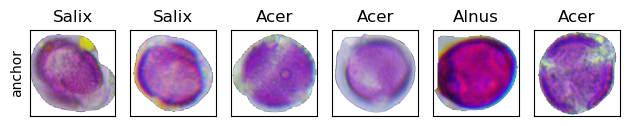

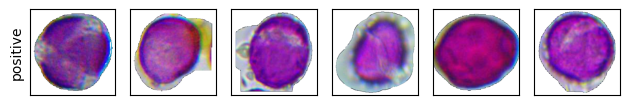

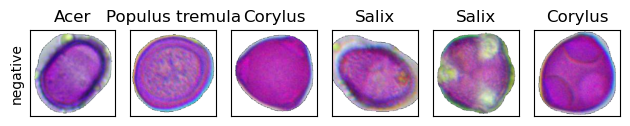

In [15]:
for anchor, positive, negative, label, negative_label in training_loader:
    plot(anchor[:6], row_title=["anchor"], labels=label[:6])
    plot(positive[:6], row_title=["positive"])
    plot(negative[:6], row_title=["negative"], labels=negative_label[:6])
    break

In [29]:
class EmbeddingModel(nn.Module):
    def __init__(self, embeddings=64):
        super().__init__()
        self.model = models.resnet18(weights='DEFAULT')
        num_features = self.model.fc.in_features
        self.model.fc = nn.Identity()
        self.embeddings = nn.Linear(num_features, embeddings)

    def forward(self, x):
        x = self.model(x)
        x = self.embeddings(x)
        x = nn.functional.normalize(x) # L2 normalization to put all values on a sphere
        return x

class CircleLoss(nn.Module):
    def __init__(self, m=0.25, gamma=256):
        super(CircleLoss, self).__init__()
        self.m = m
        self.gamma = gamma
        self.soft_plus = nn.Softplus()

    def forward(self, sp, sn):
        ap = torch.clamp_min(- sp.detach() + 1 + self.m, min=0.)
        an = torch.clamp_min(sn.detach() + self.m, min=0.)

        delta_p = 1 - self.m
        delta_n = self.m

        logit_p = - ap * (sp - delta_p) * self.gamma
        logit_n = an * (sn - delta_n) * self.gamma

        loss = self.soft_plus(torch.logsumexp(logit_n, dim=0) + torch.logsumexp(logit_p, dim=0))

        return loss

class PollenEmbedingsModule(L.LightningModule):
    def __init__(self, check_val=20, config={}):
        super().__init__()
        embedings_size = 64
        self.model = EmbeddingModel(embedings_size)
        config["backbone"]="resnet18"
        config["embedings_size"]=embedings_size
        config["check_val"]=check_val
        config["optim_lr"]=0.001
        config["optim_betas"]=(0.9, 0.999)
        config["optim_eps"]=1e-08
        config["optim_weight_decay"]=0
        # call this to save (arguments) to the checkpoint
        self.save_hyperparameters(config)

        self.loss_function = CircleLoss()
        self.best_score = 0
        self.best_val_epoch = -1

        self.train_step_outputs = []
        self.validation_step_outputs = []
        self.train_losses = []
        self.val_losses = []
        self.to(self.device)

    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        anchor, positive, negative, label, _ = batch

        anchor_out = self.model(anchor)
        positive_out = self.model(positive)
        negative_out = self.model(negative)

        sp = TF.cosine_similarity(anchor_out, positive_out)
        sn = TF.cosine_similarity(anchor_out, negative_out)
        
        loss = self.loss_function(sp, sn)
        pred = {"train_loss": loss, "train_number": len(anchor_out)}
        self.train_step_outputs.append(pred)
        return loss

    def on_train_epoch_end(self):
        outputs = self.train_step_outputs
        train_loss, num_items = 0, 0
        for output in outputs:
            train_loss += output["train_loss"].sum().item()
            num_items += output["train_number"]

        mean_train_loss = torch.tensor(train_loss / num_items)
        self.log("train_loss", mean_train_loss)
        self.train_losses.append(mean_train_loss.item())
        self.train_step_outputs.clear()  # free memory

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        anchor, positive, negative, label, _ = batch

        anchor_out = self.model(anchor)
        positive_out = self.model(positive)
        negative_out = self.model(negative)

        sp = TF.cosine_similarity(anchor_out, positive_out)
        sn = TF.cosine_similarity(anchor_out, negative_out)
        
        loss = self.loss_function(sp, sn)
        
        pred = {"val_loss": loss, "val_number": len(anchor_out)}
        self.validation_step_outputs.append(pred)
        # return {"val_loss": loss}

    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        val_loss, num_items = 0, 0
        for output in outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]

        mean_val_loss = torch.tensor(val_loss / num_items)
        self.val_losses.append(mean_val_loss.item())

        tensorboard_logs = {
            "val_loss": mean_val_loss
        }
        self.log("val_loss", mean_val_loss)
        self.validation_step_outputs.clear()  # free memory

        if mean_val_loss > self.best_score:
            self.best_score = mean_val_loss
            self.best_val_epoch = self.current_epoch

        return {"log": tensorboard_logs}

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=self.hparams.optim_lr,
                                          betas=self.hparams.optim_betas,
                                          eps=self.hparams.optim_eps,
                                          weight_decay=self.hparams.optim_weight_decay)
        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": ReduceLROnPlateau(self.optimizer, factor=0.1, patience=10),
                "frequency": self.hparams.check_val,
                "monitor": "val_loss",
                "interval": "epoch",
            }
        }

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot([i * self.hparams.check_val for i in range(len(self.val_losses))], self.val_losses, label='Validation Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses')
        plt.legend()
        plt.show()

In [30]:
model = PollenEmbedingsModule(check_val=5)

In [31]:
model = model.to(device)
summary(model.model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [32]:
checkpoint_callback = ModelCheckpoint(
    filename='checkpoint-{epoch:02d}-{val_loss:.2f}',
    # auto_insert_metric_name=False,
    dirpath="./history",
    monitor='val_loss',
    mode='min')
lr_logger = LearningRateMonitor()
logger = CSVLogger("logs", name="triplet_1")

In [33]:
trainer = L.Trainer(logger=logger,
                    log_every_n_steps=1,  # Increase, if epoch size is large
                    callbacks=[checkpoint_callback, lr_logger],
                    precision="16-mixed",
                    check_val_every_n_epoch=model.hparams.check_val,
                    max_epochs=10,
                    accumulate_grad_batches=2,
                    )

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [34]:
trainer.fit(model, 
            train_dataloaders=training_loader, 
            val_dataloaders=val_loader,     
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type           | Params
-------------------------------------------------
0 | model         | EmbeddingModel | 11.2 M
1 | loss_function | CircleLoss     | 0     
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.837    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


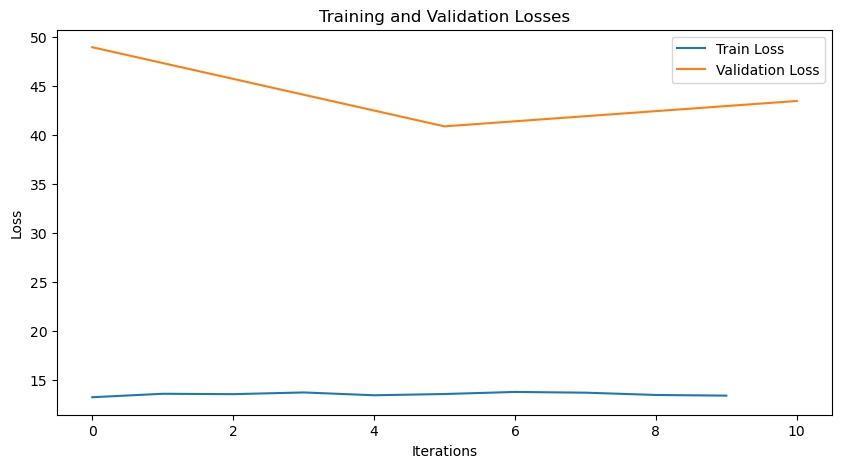

In [35]:
model.plot_losses()

In [ ]:
# Loading the model

In [37]:
checkpoint_path = "/home/jovyan/git/Pollen-Analyzer/Classification/history/checkpoint-epoch=04-val_loss=40.86.ckpt"
model = PollenEmbedingsModule.load_from_checkpoint(checkpoint_path)

In [38]:
model.eval()
model = model.cuda()

In [39]:
def plot_matrix(embeddings_list: list, labels_list: list, subtitle: str=None, axes_class_markings: bool=True):
    class_to_idx = {}
    for i, class_name in enumerate(np.unique(labels_list)):
        class_to_idx[class_name] = i
    all_labels_idx = [class_to_idx[label] for label in labels_list]
    sorted_indices = sorted(range(len(embeddings_list)), key=lambda i: all_labels_idx[i])
    all_embeddings_sorted = [embeddings_list[i] for i in sorted_indices]
    all_labels_sorted = [all_labels[i] for i in sorted_indices]

    class_boundaries = [0]
    for i in range(1, len(all_labels_sorted)):
        if all_labels_sorted[i] != all_labels_sorted[i-1]:
            class_boundaries.append(i)
    class_boundaries.append(len(all_labels_sorted))

    pairwise_dist = pairwise_distances(all_embeddings_sorted)
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(pairwise_dist, cmap='Blues_r')
    plt.colorbar(im)

    if axes_class_markings:
        tick_locs = [(class_boundaries[i] + class_boundaries[i+1] - 1) / 2 for i in range(len(class_boundaries)-1)]
        ax.set_xticks(tick_locs)
        ax.set_yticks(tick_locs)
        ax.set_xticklabels([all_labels_sorted[int(loc)] for loc in tick_locs])
        ax.set_yticklabels([all_labels_sorted[int(loc)] for loc in tick_locs])
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        for boundary in class_boundaries[1:-1]:
            ax.axhline(y=boundary-1, color='w', linestyle='-', linewidth=0.5)
            ax.axvline(x=boundary-1, color='w', linestyle='-', linewidth=0.5)
    if subtitle != None:
        plt.title('Pairwise Distance Matrix\n' + subtitle)
    else:
        plt.title('Pairwise Distance Matrix')
    plt.tight_layout()
    plt.show()

In [42]:
loaders_list = [test_loader, val_loader, training_loader]
all_embeddings = []
all_labels = []
with torch.no_grad():
    for loader in loaders_list:
        for batch in tqdm(loader):
            imgs, _, _, labels, _ = batch
            imgs = imgs.cuda()
            embeddings = model(imgs)
            all_embeddings.append(embeddings.cpu())
            all_labels.extend(labels)
all_embeddings = torch.cat(all_embeddings, dim=0).cpu().numpy()

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

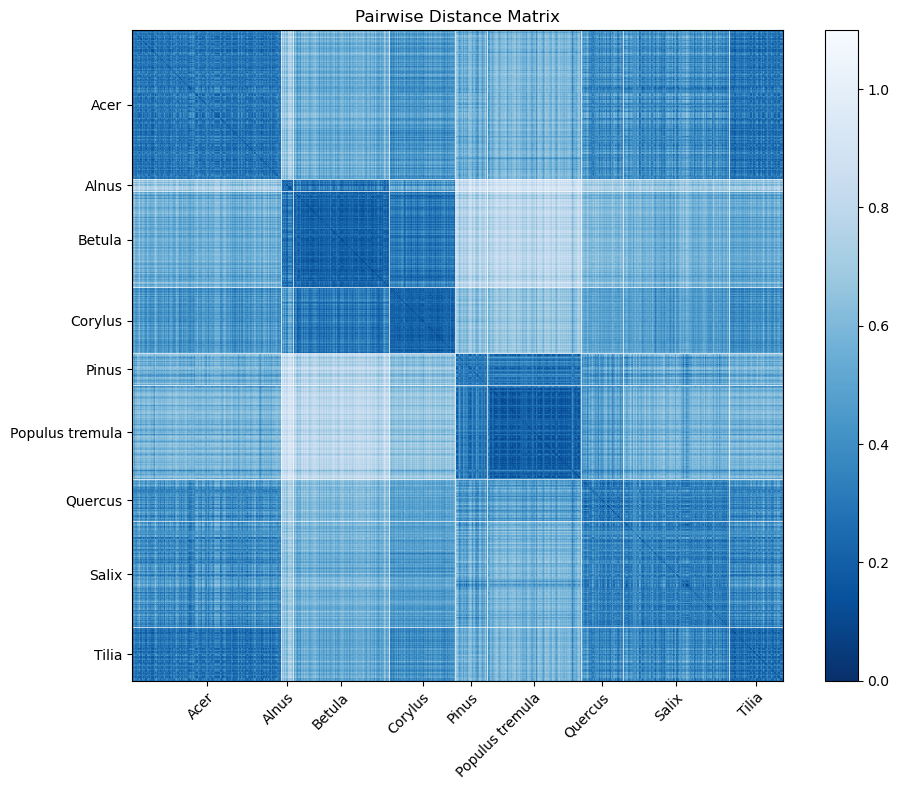

In [43]:
plot_matrix(all_embeddings, all_labels)

In [45]:
loaders_list = [test_loader]
all_embeddings = []
all_labels = []
with torch.no_grad():
    for loader in loaders_list:
        for batch in tqdm(loader):
            imgs, _, _, labels, _ = batch
            imgs = imgs.cuda()
            embeddings = model(imgs)
            all_embeddings.append(embeddings.cpu())
            all_labels.extend(labels)
all_embeddings = torch.cat(all_embeddings, dim=0).cpu().numpy()

  0%|          | 0/181 [00:00<?, ?it/s]

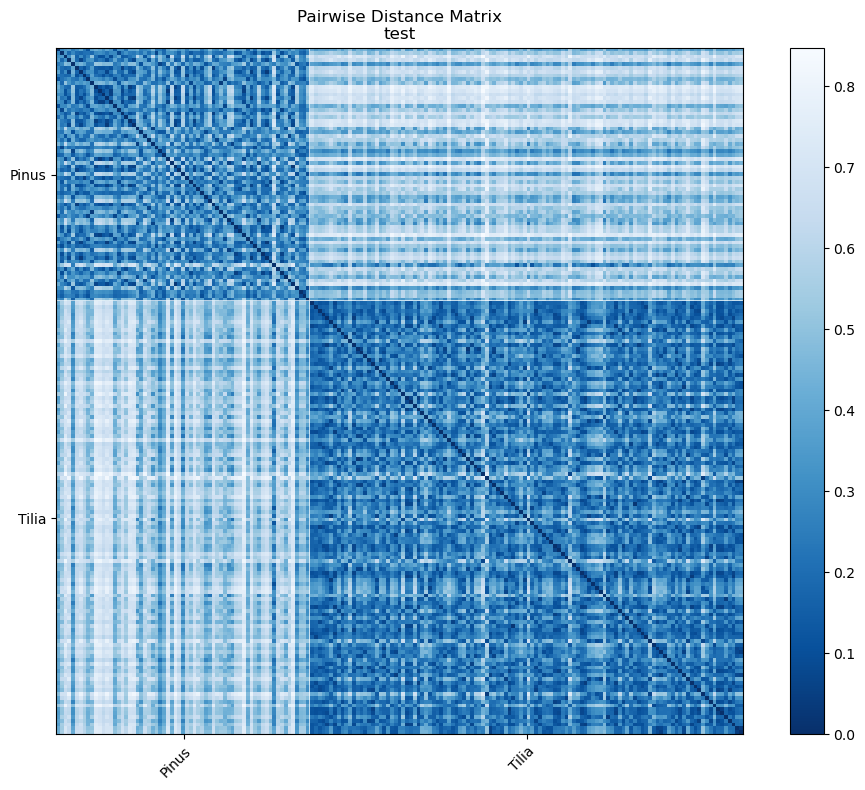

In [46]:
plot_matrix(all_embeddings, all_labels, 'test')